In [1]:
%run /work/jupyter_notebooks/gene\ family\ distances/correlate_evolution.ipynb

%cd /work/clusterEvo/new_tests/eggNOG/duplications/

/work/clusterEvo/new_tests/eggNOG/duplications


In [2]:
import multiprocessing
import itertools
import pandas as pd
import plotly
from scipy.stats import pearsonr, mannwhitneyu
from scipy.spatial.distance import braycurtis
import igraph as ig
from Bio import SeqIO
import requests
from ftplib import FTP
from time import sleep

In [3]:
eggNOG_trees = pd.read_csv('../2157_trees.tsv',
                           sep      ='\t',
                           header   =None,
                           usecols  =[1,2,3],
                           index_col=0,
                           names    =['group_id', 'fast', 'tree'])

In [4]:
duplicated_genes = pd.read_csv('duplicated_genes.tsv', sep='\t', index_col=0)

duplicated_genes.taxa    = duplicated_genes.taxa.map(   lambda cell: cell.strip('[]').split(', '))
duplicated_genes.members = duplicated_genes.members.map(lambda cell: cell.split(','))
duplicated_genes.head()

eggNOG_trees = eggNOG_trees.reindex(index=duplicated_genes.group_id)

In [5]:
duplicated_genes.shape

(1823, 5)

In [6]:
representatives = duplicated_genes.query('num_taxa     == 168 & '
                                         'num_proteins == 168').iloc[0,3]

In [335]:
missing = []
for tmp in representatives.split(','):
    tmp = tmp.split('.')
    taxid = tmp[0]
    locus_tag = '.'.join(tmp[1:])
    
    if os.path.isfile(f'/work/clusterEvo/new_tests/eggNOG/duplications/genomes/{taxid}.gb.gz'):
        continue
    
    try:
        gene_id = re.search('<Id>(\d+)<\/Id>',
                            requests.get('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?'
                                         'db=gene&'
                                        f'term={locus_tag}').text).group(1)
    except AttributeError:
        missing.append([taxid, locus_tag])
        continue
    finally:
        sleep(1)
        
    chr_accession = re.search('<Gene-source_src-str1>(\S+)</Gene-source_src-str1>',
                              requests.get('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?'
                                           'db=gene&'
                                           'retmode=xml&'
                                          f'id={gene_id}').text).group(1)
    
    sleep(1)
    
    try:
        assembly_acc = re.search('Assembly:\s+(\S+)\.\d+',
                                  requests.get('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?'
                                               'db=nuccore&'
                                               'retmode=text&'
                                               'rettype=gb&'
                                              f'id={chr_accession}').text).group(1)
    except AttributeError:
        missing.append([taxid, locus_tag])
        continue

    assembly_acc = assembly_acc.replace('GCF_', 'GCA')
    genome_folder = '/'.join([assembly_acc[pos:pos+3] for pos in range(0, len(assembly_acc), 3)])
    
    ftp = FTP('ftp.ncbi.nlm.nih.gov')       # connect to host, default port
    ftp.login()                             # user anonymous, passwd anonymous@
    ftp.cwd(f'genomes/all/{genome_folder}') # change into "debian" directory
    ftp.cwd(ftp.nlst()[0])
    
    for filename in ftp.nlst():
        if filename.endswith('gbff.gz'):
            print(filename, taxid)

            with open(f'/work/clusterEvo/new_tests/eggNOG/duplications/genomes/{taxid}.gb.gz', 'wb') as out:
                ftp.retrbinary(f'RETR {filename}', out.write)
            
            break
    
    sleep(1)
#     break

In [381]:
with cd('genomes/'):
    for filename in os.listdir('.'):
        if not filename.endswith('.gz'):
            continue

        subprocess.call(['gunzip', '-d', filename])

In [8]:
if not os.path.isfile('genomic_position_of_genes.parquet'):
    gene_positions = pd.DataFrame(columns=['taxid', 'replicon', 'start', 'end'])

    for filename in os.listdir('genomes/'):
        if not filename.endswith('.gb') or filename.startswith('.'):
            continue

        taxid = filename.replace('.gb', '')

        gb = SeqIO.parse(f'genomes/{filename}', 'gb')

        for entry in gb:

            for feat in entry.features:

                if feat.type != 'CDS' or 'locus_tag' not in feat.qualifiers:
                    continue

                locus_tag = feat.qualifiers['locus_tag'][0]
                gene_positions.loc[locus_tag] = [taxid,
                                                 entry.name,
                                                 feat.location.start.position, 
                                                 feat.location.end.position]
    #         break
    #     break

    gene_positions.to_parquet('genomic_position_of_genes.parquet')
    gene_positions.to_csv(    'genomic_position_of_genes.tsv', sep='\t')
else:
    gene_positions = pd.read_parquet('genomic_position_of_genes.parquet')

wrong_taxids   = ['272557', '70601']
gene_positions = gene_positions.query('taxid not in @wrong_taxids').copy()

sampled_taxids = gene_positions.taxid.unique()

In [9]:
replicon_sizes = pd.DataFrame(columns=['taxid', 'replicon', 'length'])
for filename in os.listdir('genomes/'):
    if not filename.endswith('.gb') or filename.startswith('.'):
        continue

    taxid = filename.replace('.gb', '')
    gb    = SeqIO.parse(f'genomes/{filename}', 'gb')
    
    for entry in gb:

        replicon_sizes = replicon_sizes.append(
            pd.Series(index=['taxid', 
                             'replicon', 
                             'length'],
                      data =[taxid,
                             entry.name,
                             len(entry)]),
            ignore_index=True
        )

replicon_sizes.to_csv('replicon_sizes.tsv', sep='\t')

In [8]:
recruited_seqs = []
for index, row in few_duplications.iterrows():
    recruited_seqs.extend(
        re.findall(f'(?:^|,)[^.]+\.([^,]+)', row.members)
    )

gene_positions = gene_positions.reindex(index=recruited_seqs).dropna(how='any')
gene_positions.drop_duplicates(inplace=True)

In [10]:
def get_distance_between_genes(gene_positions):
    
    gene_distances = pd.DataFrame(columns=['group1', 
                                           'group2', 
                                           'distance'])
    for (index1, row1), (index2, row2) in itertools.combinations(gene_positions.iterrows(), 2):

        dist_possibility1 = abs(row1.end - row2.start)
        dist_possibility2 = abs(row2.end - row1.start)

        if dist_possibility1 <= dist_possibility2:
            dist_between_pair = dist_possibility1
        else:
            dist_between_pair = dist_possibility2

        gene_distances = gene_distances.append(
            pd.Series(index=['group1', 
                             'group2', 
                             'distance'],
                      data =[index1,
                             index2,
                             dist_between_pair]),
            ignore_index=True
        )
    
    return(gene_distances)

In [10]:
group_ids = []
trees     = []
for index, row in eggNOG_trees.iterrows():
    group_ids.append(index)
    trees.append(ete3.Tree(row.tree))

pool          = multiprocessing.Pool(processes = 10)
dist_matrices = pool.map(get_matrix_from_tree, trees)
pool.close()
pool.join()

table = {group:matrix.copy() for group, matrix in zip(group_ids, dist_matrices)}

In [12]:
#
# odr
odr_df = pd.read_parquet('neighboring_duplicated_genes_Rsquared.parquet')

odr_df['group_pair'] = odr_df[['group1', 'group2']].agg(frozenset, axis=1)
odr_df.set_index('group_pair', inplace=True)

#
# bray-curtis
braycurtis_df = pd.read_parquet('neighboring_duplicated_genes_braycurtis.parquet')

braycurtis_df['group_pair'] = braycurtis_df[['group1', 'group2']].agg(frozenset, axis=1)
braycurtis_df.set_index('group_pair', inplace=True)

#
# combine
odr_df = odr_df.join(braycurtis_df.braycurtis)
odr_df['coevol_metric'] = odr_df.Rsquared * (odr_df.braycurtis**2)

odr_df.reset_index(drop=False, inplace=True)
odr_df.drop_duplicates(subset='group_pair', inplace=True)
odr_df.drop(columns='group_pair', inplace=True)

odr_df.head()

,group1,group2,Rsquared,braycurtis,coevol_metric
0,arCOG00918,arCOG01036,0.855133,0.862275,0.635808
4,arCOG01545,arCOG01537,0.798697,0.448898,0.160945
8,arCOG01548,arCOG04537,0.461398,0.421456,0.081956
12,arCOG01548,arCOG01543,0.945338,0.625821,0.370243
16,arCOG01548,arCOG01539,0.789667,0.761155,0.457499


In [13]:
string = pd.read_parquet('duplicated_genes-string.parquet')

string['group_pair'] = string[['group1', 'group2']].agg(frozenset, axis=1)
string.drop_duplicates(subset='group_pair', inplace=True)

neighors     = string.query('neighborhood >= 700')
not_neighors = string.query('neighborhood <= 200')

In [15]:
neighors.head()

,group1,group2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,group_pair
388,arCOG00918,arCOG01036,727,0,358,55,425,450,499,967,"(arCOG01036, arCOG00918)"
2456,arCOG00495,arCOG00862,770,830,706,490,179,450,499,998,"(arCOG00495, arCOG00862)"
3482,arCOG00495,arCOG00914,709,0,279,489,0,450,499,965,"(arCOG00495, arCOG00914)"
5391,arCOG04397,arCOG02305,814,688,143,440,486,0,499,991,"(arCOG02305, arCOG04397)"
12275,arCOG00644,arCOG02055,708,0,392,355,30,450,499,962,"(arCOG02055, arCOG00644)"


In [34]:
odr_df.head()

,group1,group2,Rsquared,braycurtis,coevol_metric
group_pair,,,,,
"(arCOG00918, arCOG01036)",arCOG00918,arCOG01036,0.855133,0.862275,0.635808
"(arCOG00918, arCOG01036)",arCOG00918,arCOG01036,0.855133,0.862275,0.635808
"(arCOG00918, arCOG01036)",arCOG01036,arCOG00918,0.835953,0.862275,0.621547
"(arCOG00918, arCOG01036)",arCOG01036,arCOG00918,0.835953,0.862275,0.621547
"(arCOG01537, arCOG01545)",arCOG01545,arCOG01537,0.798697,0.448898,0.160945


In [19]:
assessed_groups

45

In [83]:
distances_between_single_copies    = []
distances_between_matching_pairs   = []
distances_between_unmatching_pairs = []

weird_group_pair = []
closest, not_closest = 0, 0

assessed_groups = 0
# for group1, group2 in [('arCOG00018', 'arCOG00035')]:
# for group1, group2 in itertools.combinations(clusters.subgraph(3).vs['name'], 2):
for index, row in neighors.iterrows():
    
    group1 = row.group1
    group2 = row.group2

    pair = (group1, group2)
    if odr_df.query('group1 in @pair and group2 in @pair').coevol_metric.squeeze() < 0.9:
#     string_query = string.query('group1 in @pair & '
#                                 'group2 in @pair')
#     if not string_query.shape[0] or string_query.neighborhood.squeeze() < 700:
        continue
    
    #################################################################################
    matrix1 = table[group1].copy()
    matrix2 = table[group2].copy()

    matrix1, taxa1, matrix2, taxa2 = balance_matrices(matrix1, 
                                                      matrix2, 
                                                      gene_sep='.')

    #################################################################################

    duplicated_taxa = set()
    
    tmp1 = duplicated_genes.query('group_id ==  @group1').squeeze()
    for taxon, count in Counter( [member.split('.')[0]
                                  for member in tmp1.members] ).items():
        if count > 1:
            duplicated_taxa.add(taxon)
            
    tmp2 = duplicated_genes.query('group_id ==  @group2').squeeze()
    for taxon, count in Counter( [member.split('.')[0]
                                  for member in tmp2.members] ).items():
        if count > 1:
            duplicated_taxa.add(taxon)

    duplicated_taxa.intersection_update(sampled_taxids)
    
    if duplicated_taxa:
        assessed_groups += 1

    #################################################################################
    
    duplicated_genes_group1 = {taxon:[] for taxon in duplicated_taxa}
    for member in tmp1.members:
        tmp_taxid = member.split('.')[0]
        if tmp_taxid in duplicated_taxa:
            duplicated_genes_group1[tmp_taxid].append( '.'.join(member.split('.')[1:]) )
    
    duplicated_genes_group2 = {taxon:[] for taxon in duplicated_taxa}
    for member in tmp2.members:
        tmp_taxid = member.split('.')[0]
        if tmp_taxid in duplicated_taxa:
            duplicated_genes_group2[tmp_taxid].append( '.'.join(member.split('.')[1:]) )
    
    for taxid in duplicated_taxa:
        group1_genes = duplicated_genes_group1[taxid]
        group2_genes = duplicated_genes_group2[taxid]
        
    #################################################################################
    
        gene_distances = pd.DataFrame(columns=['gene1', 'gene2', 'distance'])
        for gene1, gene2 in itertools.product(gene_positions.index.intersection(group1_genes),
                                              gene_positions.index.intersection(group2_genes)):

            row1 = gene_positions.loc[gene1].squeeze()
            row2 = gene_positions.loc[gene2].squeeze()

            if row1.replicon != row2.replicon:
                tmp_dists = [replicon_sizes.query('replicon == @row1.replicon').length.squeeze(),
                             replicon_sizes.query('replicon == @row2.replicon').length.squeeze()]
                gene_distances = gene_distances.append(
                    pd.Series(index=['gene1', 
                                     'gene2', 
                                     'distance'],
                              data =[gene1, 
                                     gene2, 
                                     np.max(tmp_dists)]),
                    ignore_index=True
                )

            else:
                gene1_positions = sorted(row1[['start', 'end']].tolist())
                gene2_positions = sorted(row2[['start', 'end']].tolist())

                distance_possibilities = [abs(gene1_positions[1] - gene2_positions[0])]
                distance_possibilities.append(
                    gene1_positions[0] + \
                    (replicon_sizes.query('replicon == @row2.replicon').length.squeeze() - gene2_positions[1])
                )

                gene_distances = gene_distances.append(
                    pd.Series(index=['gene1', 
                                     'gene2', 
                                     'distance'],
                              data =[gene1,
                                     gene2,
                                     np.min(distance_possibilities)]),
                    ignore_index=True
                )

    #################################################################################
    
        selected_genes1 = taxa1.query(f'genome == "{taxid}"').gene
        selected_genes2 = taxa2.query(f'genome == "{taxid}"').gene
        
        for selected1, selected2 in zip(selected_genes1.tolist(), 
                                        selected_genes2.tolist()):
            
            if selected1 not in gene_positions.index or selected2 not in gene_positions.index:
                continue
                
            tmp_matching_distance = gene_distances.query(
                'gene1 == @selected1 & '
                'gene2 == @selected2'
            ).distance.squeeze()
            
#             tmp_unmatching_distance = gene_distances.query(
#                 '(gene1 ==  @selected1 & gene2 !=  @selected2) | '
#                 '(gene1 !=  @selected1 & gene2 ==  @selected2)'
#             ).distance.tolist()

            tmp_unmatching_distance = []
            for tmp in gene_distances.query(
                '(gene1 ==  @selected1 & gene2 !=  @selected2) | '
                '(gene1 !=  @selected1 & gene2 ==  @selected2)'
            ).distance.tolist():
                tmp_distance_difference = abs(tmp_matching_distance - tmp)
                if tmp_distance_difference >= tmp_matching_distance:
                    tmp_unmatching_distance.append(tmp)
            
            if not tmp_unmatching_distance:
                continue
            
            distances_between_matching_pairs.append(    tmp_matching_distance)
            distances_between_unmatching_pairs.extend(tmp_unmatching_distance)
            
            flag = False
            for n in tmp_unmatching_distance:
                if n < tmp_matching_distance:
                    flag = True
                    weird_group_pair.append( frozenset([group1, group2]) )
                    break
            if flag:
                not_closest += 1
            else:
                closest += 1

    #################################################################################

    if not duplicated_taxa:
        continue
    
    single_copy_taxa = set(taxa1.genome.tolist())
    single_copy_taxa.difference_update(duplicated_taxa)
    single_copy_taxa.intersection_update(sampled_taxids)

    for taxid in single_copy_taxa:
        
        gene1 = ['.'.join(gene.split('.')[1:]) 
                 for gene in duplicated_genes.query('group_id == @group1').members.squeeze()
                 if gene.startswith(str(taxid))]
        gene2 = ['.'.join(gene.split('.')[1:]) 
                 for gene in duplicated_genes.query('group_id == @group2').members.squeeze()
                 if gene.startswith(str(taxid))]
            
        row1 = gene_positions.loc[gene1].squeeze()
        row2 = gene_positions.loc[gene2].squeeze()

        if row1.replicon != row2.replicon:
            tmp_dists = [replicon_sizes.query('replicon == @row1.replicon').length.squeeze(),
                         replicon_sizes.query('replicon == @row2.replicon').length.squeeze()]
            distance_possibilities.append(np.max(tmp_dists))
            continue

        gene1_positions = sorted(row1[['start', 'end']].tolist())
        gene2_positions = sorted(row2[['start', 'end']].tolist())

        distance_possibilities = [abs(gene1_positions[1] - gene2_positions[0])]
        distance_possibilities.append(
            gene1_positions[0] + \
            (replicon_sizes.query('replicon == @row2.replicon').length.squeeze() - gene2_positions[1])
        )
        
        distances_between_single_copies.append( np.min(distance_possibilities) )

#     break

In [71]:
len(distances_between_single_copies), len(distances_between_matching_pairs), len(distances_between_unmatching_pairs)

(4336, 226, 463)

In [84]:
len(distances_between_single_copies), len(distances_between_matching_pairs), len(distances_between_unmatching_pairs)

(4336, 200, 417)

In [73]:
len(distances_between_single_copies), len(distances_between_matching_pairs), len(distances_between_unmatching_pairs)

(4336, 115, 235)

In [79]:
mannwhitneyu(distances_between_matching_pairs,
             distances_between_unmatching_pairs), \
cles(distances_between_matching_pairs,
             distances_between_unmatching_pairs)

(MannwhitneyuResult(statistic=870.0, pvalue=3.45072855372168e-46),
 0.9678075855689177)

In [82]:
mannwhitneyu(distances_between_matching_pairs,
             distances_between_single_copies), \
cles(distances_between_matching_pairs,
             distances_between_single_copies)

(MannwhitneyuResult(statistic=114939.0, pvalue=2.5416209727997794e-23),
 0.7685103481469597)

In [81]:
mannwhitneyu(distances_between_unmatching_pairs,
             distances_between_single_copies), \
cles(distances_between_single_copies,
             distances_between_unmatching_pairs)

(MannwhitneyuResult(statistic=239131.5, pvalue=3.805402260743192e-43),
 0.765317578707702)

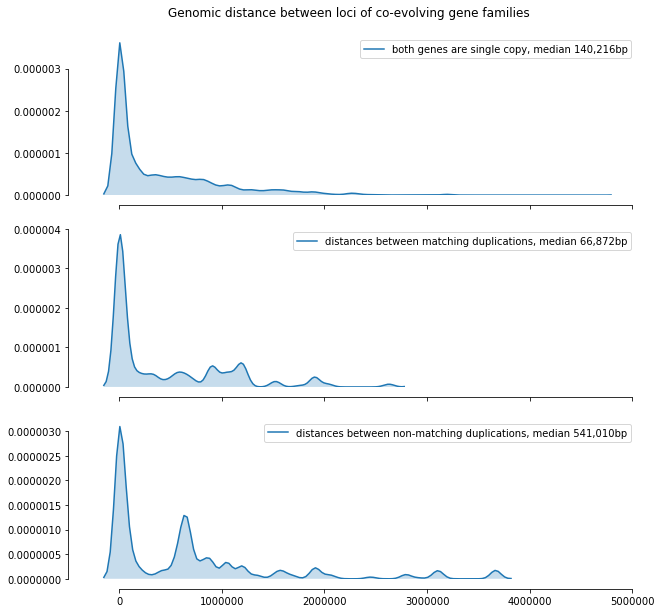

In [18]:
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(10, 10))

sns.kdeplot(distances_between_single_copies,    
            label=f'both genes are single copy, \
median {np.median(distances_between_single_copies):,.0f}bp',  
            bw=50000, shade=True, ax=axs[0])
sns.kdeplot(distances_between_matching_pairs,   
            label=f'distances between matching duplications, \
median {np.median(distances_between_matching_pairs):,.0f}bp',     
            bw=50000, shade=True, ax=axs[1])
sns.kdeplot(distances_between_unmatching_pairs, 
            label=f'distances between non-matching duplications, \
median {np.median(distances_between_unmatching_pairs):,.0f}bp', 
            bw=50000, shade=True, ax=axs[2])

fig.suptitle('Genomic distance between loci of co-evolving gene families', y=0.92);

sns.despine(offset=10, trim=True);

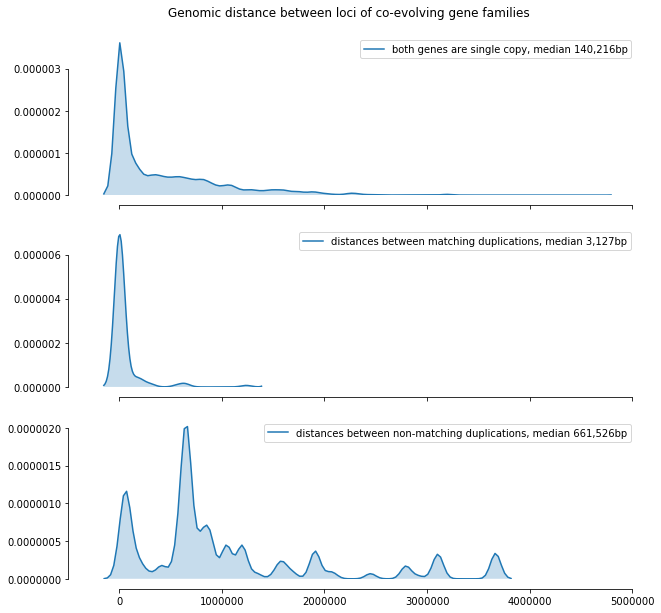

In [74]:
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(10, 10))

sns.kdeplot(distances_between_single_copies,    
            label=f'both genes are single copy, \
median {np.median(distances_between_single_copies):,.0f}bp',  
            bw=50000, shade=True, ax=axs[0])
sns.kdeplot(distances_between_matching_pairs,   
            label=f'distances between matching duplications, \
median {np.median(distances_between_matching_pairs):,.0f}bp',     
            bw=50000, shade=True, ax=axs[1])
sns.kdeplot(distances_between_unmatching_pairs, 
            label=f'distances between non-matching duplications, \
median {np.median(distances_between_unmatching_pairs):,.0f}bp', 
            bw=50000, shade=True, ax=axs[2])

fig.suptitle('Genomic distance between loci of co-evolving gene families', y=0.92);

sns.despine(offset=10, trim=True);

In [78]:
random.seed(12345)
example_tree1 = ete3.Tree()
example_tree1.populate(10, 
                       random_branches=True,
                       names_library=['a.1', 'b.1', 'c.1', 'd.1', 'e.1',
                                      'f.1', 'g.1', 'h.1', 'i.1', 'j.1'])

In [79]:
example_tree2 = example_tree1.copy()

donor_node = next( example_tree2.iter_search_nodes(name='c.1') )

recipient_node = donor_node.add_sister(name='j.2', dist=random.random())
example_tree2.resolve_polytomy()

recipient_node.get_sisters()[0].dist  *= 0.5
recipient_node.get_ancestors()[0].dist = recipient_node.get_sisters()[0].dist

In [80]:
print(example_tree2)


         /-h.1
      /-|
     |  |   /-g.1
     |   \-|
     |      \-f.1
   /-|
  |  |      /-e.1
  |  |   /-|
  |  |  |   \-d.1
  |  |  |
  |   \-|         /-b.1
  |     |      /-|
--|     |   /-|   \-a.1
  |     |  |  |
  |      \-|   \-j.2
  |        |
  |         \-c.1
  |
  |   /-j.1
   \-|
      \-i.1


In [89]:
example_matrix1 = get_matrix_from_tree(example_tree1)
example_matrix2 = get_matrix_from_tree(example_tree2)

In [94]:
example_matrix1

,j.1,i.1,h.1,g.1,f.1,e.1,d.1,c.1,b.1,a.1
j.1,0.000000,1.266433,3.073115,2.570989,3.054829,4.022448,3.952977,3.347015,3.032989,3.323965
i.1,1.266433,0.000000,3.277462,2.775337,3.259176,4.226796,4.157324,3.551363,3.237337,3.528313
h.1,3.073115,3.277462,0.000000,0.935809,1.419648,2.927757,2.858286,2.252324,1.938298,2.229275
g.1,2.570989,2.775337,0.935809,0.000000,0.537580,2.425632,2.356160,1.750199,1.436172,1.727149
f.1,3.054829,3.259176,1.419648,0.537580,0.000000,2.909471,2.840000,2.234038,1.920012,2.210989
e.1,4.022448,4.226796,2.927757,2.425632,2.909471,0.000000,1.811005,2.329201,2.015175,2.306151
d.1,3.952977,4.157324,2.858286,2.356160,2.840000,1.811005,0.000000,2.259729,1.945703,2.236680
c.1,3.347015,3.551363,2.252324,1.750199,2.234038,2.329201,2.259729,0.000000,0.991055,1.282031
b.1,3.032989,3.237337,1.938298,1.436172,1.920012,2.015175,1.945703,0.991055,0.000000,0.756219
a.1,3.323965,3.528313,2.229275,1.727149,2.210989,2.306151,2.236680,1.282031,0.756219,0.000000


In [95]:
example_matrix2

,j.1,i.1,h.1,g.1,f.1,e.1,d.1,c.1,j.2,b.1,a.1
j.1,0.000000,1.266433,3.073115,2.570989,3.054829,4.022448,3.952977,3.347015,3.554546,3.032989,3.323965
i.1,1.266433,0.000000,3.277462,2.775337,3.259176,4.226796,4.157324,3.551363,3.758894,3.237337,3.528313
h.1,3.073115,3.277462,0.000000,0.935809,1.419648,2.927757,2.858286,2.252324,2.459855,1.938298,2.229275
g.1,2.570989,2.775337,0.935809,0.000000,0.537580,2.425632,2.356160,1.750199,1.957729,1.436172,1.727149
f.1,3.054829,3.259176,1.419648,0.537580,0.000000,2.909471,2.840000,2.234038,2.441569,1.920012,2.210989
e.1,4.022448,4.226796,2.927757,2.425632,2.909471,0.000000,1.811005,2.329201,2.536732,2.015175,2.306151
d.1,3.952977,4.157324,2.858286,2.356160,2.840000,1.811005,0.000000,2.259729,2.467260,1.945703,2.236680
c.1,3.347015,3.551363,2.252324,1.750199,2.234038,2.329201,2.259729,0.000000,1.512611,0.991055,1.282031
j.2,3.554546,3.758894,2.459855,1.957729,2.441569,2.536732,2.467260,1.512611,0.000000,1.092692,1.383669
b.1,3.032989,3.237337,1.938298,1.436172,1.920012,2.015175,1.945703,0.991055,1.092692,0.000000,0.756219


In [99]:
def balance_matrices_all_combinations(matrix1, matrix2,  gene_sep='_'):
    
    if gene_sep == '_':
        regex = re.compile('^(GC[AF]_\d+(?:\.\d)?)[_|](.*)$')
    elif gene_sep == '.':
        regex = re.compile('^([^.]+?)\.(.*)$')
    
    tmp_taxa = []
    for index in matrix1.index:
        genome, gene = re.search(regex, index).groups()
        tmp_taxa.append([index, genome, gene])

    taxa1 = pd.DataFrame(columns=['taxon', 'genome', 'gene'],
                         data=tmp_taxa)

    tmp_taxa = []
    for index in matrix2.index:
        genome, gene = re.search(regex, index).groups()
        tmp_taxa.append([index, genome, gene])

    taxa2 = pd.DataFrame(columns=['taxon', 'genome', 'gene'],
                         data=tmp_taxa)

    shared_genomes = np.intersect1d(taxa1.genome.unique(), 
                                    taxa2.genome.unique())

    taxa1 = taxa1[taxa1.genome.isin(shared_genomes)]
    taxa2 = taxa2[taxa2.genome.isin(shared_genomes)]

    if not taxa1.genome.is_unique or not taxa2.genome.is_unique:
    
        taxa1_frequency = Counter(taxa1.genome) 
        taxa2_frequency = Counter(taxa2.genome)

        for genome in shared_genomes:
            genome1_count = taxa1_frequency[genome]
            genome2_count = taxa2_frequency[genome]

            if genome1_count > 1:
                #
                # one of the matrices must be traversed in the inversed order to make sure an 
                #     all VS all combination is obtained. That is the reason of the "iloc[::-1]"
                #     during the querying
                tmp_df = taxa2.iloc[::-1].query('genome == @genome').copy()
                for _ in range(genome1_count - 1):
                    for index, row in tmp_df.iterrows():
                        tmp_row = row.copy()
                        tmp_row.taxon += f'|{_}'
                        taxa2      = taxa2.append(tmp_row, ignore_index=True)

                        reference_name = re.sub('\|\d+$', '', tmp_row.taxon, flags=re.M)
                        matrix2[    tmp_row.taxon] = matrix2[    reference_name]
                        matrix2.loc[tmp_row.taxon] = matrix2.loc[reference_name]


            if genome2_count > 1:
                tmp_df = taxa1.query('genome == @genome').copy()
                for _ in range(genome2_count - 1):
                    for index, row in tmp_df.iterrows():
                        tmp_row = row.copy()
                        tmp_row.taxon += f'|{_}'
                        taxa1 = taxa1.append(tmp_row, ignore_index=True)

                        reference_name = re.sub('\|\d+$', '', tmp_row.taxon, flags=re.M)
                        matrix1[    tmp_row.taxon] = matrix1[    reference_name]
                        matrix1.loc[tmp_row.taxon] = matrix1.loc[reference_name]

    taxa1.sort_values('genome', inplace=True)
    taxa2.sort_values('genome', inplace=True)

    taxa1.reset_index(drop=True, inplace=True)
    taxa2.reset_index(drop=True, inplace=True)
    
#     return(taxa1, taxa2)
    
    all_taxa_pairs           = pd.DataFrame()
    all_taxa_pairs['taxon1'] = [re.sub('\|\d$', '', taxon, flags=re.M)
                                for taxon in taxa1.taxon]
    all_taxa_pairs['taxon2'] = [re.sub('\|\d$', '', taxon, flags=re.M)
                                for taxon in taxa2.taxon]
    
    matrix1 = matrix1.reindex(index  =taxa1.taxon, 
                              columns=taxa1.taxon, 
                              copy   =True)
    matrix2 = matrix2.reindex(index  =taxa2.taxon, 
                              columns=taxa2.taxon, 
                              copy   =True)
    
    return(matrix1, taxa1, matrix2, taxa2)

In [101]:
matrix1, taxa1, matrix2, taxa2 = balance_matrices_all_combinations(example_matrix1.copy(),
                                                                   example_matrix2.copy(),
                                                                   gene_sep='.')

In [104]:
condensed1 = squareform(matrix1.values, checks=False)
condensed2 = squareform(matrix2.values, checks=False)

odr_weights = estimate_weights(condensed1, condensed2)

regression = run_odr(condensed1, 
                     condensed2, 
                     *odr_weights)

mean_x = np.mean(condensed1)
mean_y = np.mean(condensed2)

mean_pred_x = regression.xplus.mean()
mean_pred_y = regression.y.mean()

x_SSres = sum(regression.delta**2)
y_SSres = sum(regression.eps  **2)
SSres   = x_SSres + y_SSres

x_SSreg = sum(
    (regression.xplus - mean_pred_x)**2
)
y_SSreg = sum(
    (regression.y     - mean_pred_y)**2
)
SSreg   = x_SSreg + y_SSreg

x_SStot = sum(
    (condensed1 - mean_x)**2
)
y_SStot = sum(
    (condensed2 - mean_y)**2
)
SStot   = x_SStot + y_SStot

r2 = 1 - SSres/SStot

In [105]:
r2

0.815714854431029

In [262]:
marker_color = []
j1_index     = []
j2_index     = []
for count, (pair1, pair2) in enumerate(zip( itertools.combinations(matrix1.index, 2),
                                            itertools.combinations(matrix2.index, 2) )):
    pair1 = [n.split('|')[0] for n in pair1]
    pair2 = [n.split('|')[0] for n in pair2]
    
    if 'j.1' not in pair1:
        marker_color.append(np.nan)
        continue
    
    if   'j.1' in pair2 and 'j.2' in pair2:
        marker_color.append(np.nan)
    elif 'j.1' in pair2:
        j1_index.append(count)
        marker_color.append('j1')
    elif 'j.2'in pair2:
        j2_index.append(count)
        marker_color.append('j2')

In [190]:
j2_index

[9, 18, 26, 33, 39, 44, 48, 51, 53]

In [179]:
regression.delta[8], regression.eps[8]

(0.01850083209832368, -0.018709112574565978)

In [180]:
regression.xplus[8], regression.y[8]

(3.3424662405204324, 3.305256295847543)

In [231]:
for count, pair2 in enumerate(itertools.combinations(matrix2.index, 2)):
    if count == 53:
        break

In [235]:
equivalent_pair1_index = ''
for count, pair1 in enumerate(itertools.combinations(matrix2.index, 2)):
    if 'i.1' in pair1 and 'j.1' in pair1:
        equivalent_pair1_index = count
        break

In [237]:
equivalent_pair1_index

52

In [279]:
yeah = pd.DataFrame(columns=['Tree1 pairwise distances', 'Tree2 pairwise distances', 'J homolog'],
                    data   =zip(condensed1, condensed2, marker_color))
yeah.dropna(inplace=True)

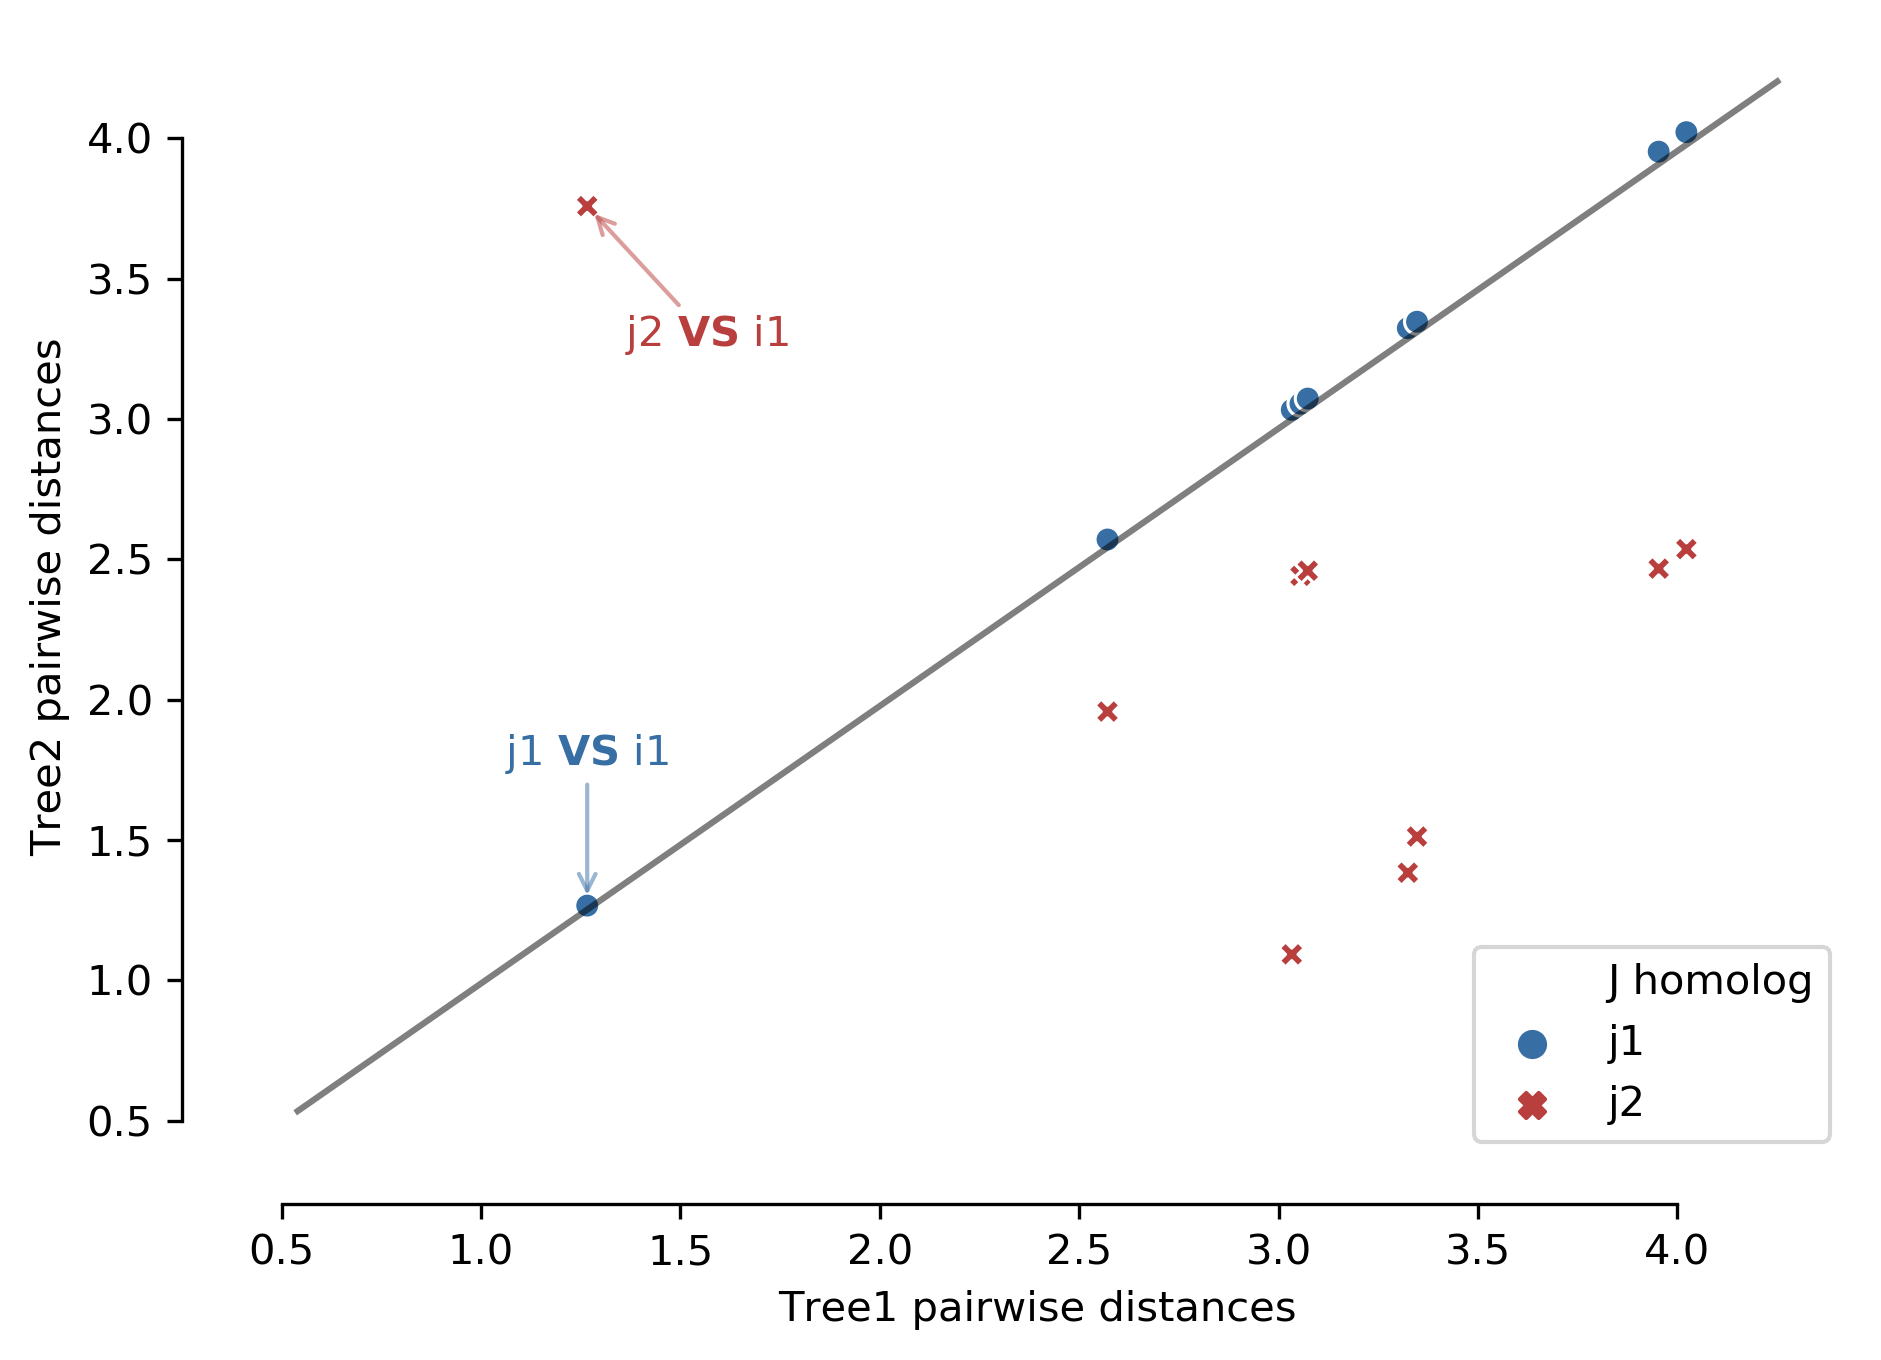

In [387]:
fig, ax = plt.subplots(dpi=300, figsize=(7, 5))

sns.lineplot(x=regression.xplus, 
             y=regression.y,
             color='k',
             alpha=0.5, 
             ax=ax)

ax.annotate(s='j2 $\\bf{VS}$ i1',
            xy=(condensed1[53], condensed2[53]), 
            xytext=(condensed1[53]+0.3, condensed2[53]-0.5), ha='center',
            arrowprops=dict(arrowstyle='->', color='#B83F3D', alpha=0.5, shrinkB=2.5, shrinkA=0),
            color='#B83F3D'
           )
ax.annotate(s='j1 $\\bf{VS}$ i1',
            xy=(condensed1[52], condensed2[52]), 
            xytext=(condensed1[52], condensed2[52]+0.5), ha='center',
            arrowprops=dict(arrowstyle='->', color='#376EA4', alpha=0.5, shrinkB=2.5, shrinkA=0),
            color='#376EA4'
           )
# ax.annotate(s='',
#             xy=(condensed1[53], condensed2[53]), 
#             xytext=(regression.xplus[53], regression.y[53]),
#             arrowprops=dict(arrowstyle='<->', color='#B83F3D', alpha=0.5, shrinkB=2.5, shrinkA=0.5)
#            )

sns.scatterplot(x    ='Tree1 pairwise distances',
                y    ='Tree2 pairwise distances', 
                hue  ='J homolog',
                style='J homolog',
                palette=['#376EA4', '#B83F3D'],
                data =yeah, 
                ax   =ax)

sns.despine(offset=10, trim=True);
fig.savefig('/Users/thiberio/Dropbox (MIT)/regression_paper/figure/matching1.pdf')

In [391]:
node_style = ete3.NodeStyle()
node_style["fgcolor"]       = "#000000"
node_style["size"]          = 0
node_style["vt_line_width"] = 2
node_style["hz_line_width"] = 2

def myLayout(node):
    node.set_style(node_style)
    
    if node.is_leaf():
        node.edited_name = ' '+node.name.replace('.', '')
        label_color = 'black'
        if node.name == 'j.1':
            label_color = '#376EA4'
        elif node.name == 'j.2':
            label_color = '#B83F3D'
        node.add_face(ete3.AttrFace("edited_name", 
                                    fsize=20,
                                    fgcolor=label_color), 
                      0, 
#                       'aligned'
                     )
        node.img_style['fgcolor'] = '#000000'
#         node.img_style['size']    = 5
    else:
        node.img_style['size'] = 0

treeStyle                    = ete3.TreeStyle()
treeStyle.layout_fn          = myLayout
treeStyle.show_leaf_name     = False
treeStyle.show_scale = False
# treeStyle.draw_guiding_lines = True

In [392]:
t = example_tree1.copy()

t.render('/Users/thiberio/Dropbox (MIT)/regression_paper/figure/matching2.pdf', tree_style=treeStyle, h=500, units='mm', dpi=300);

In [393]:
t = example_tree2.copy()
treeStyle.orientation = 1

t.render('/Users/thiberio/Dropbox (MIT)/regression_paper/figure/matching3.pdf', tree_style=treeStyle, h=500, units='mm', dpi=300);